# Clustering and differential expression analysis of PBMC2 using scanpy

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import matplotlib.pyplot as plt
from scipy.stats import rankdata

In [5]:
num_of_clusters = 16 # should be 16 for PBMC2

tool_name = 'scanpy' 
dataset_name = 'PBMC2'
data_path = '../../dataset/{}-Filtered/10x/'.format(dataset_name)
save_path = '../../results/{}/{}/'.format(dataset_name, tool_name)

if not os.path.exists(save_path):
    os.makedirs(save_path)

## Data loading and preparation

Dataset loading

In [6]:
adata = sc.read_10x_mtx(
    data_path,
    var_names='gene_symbols',
    cache=False
)
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 6019 × 13707
    var: 'gene_ids'

Studying feature variance

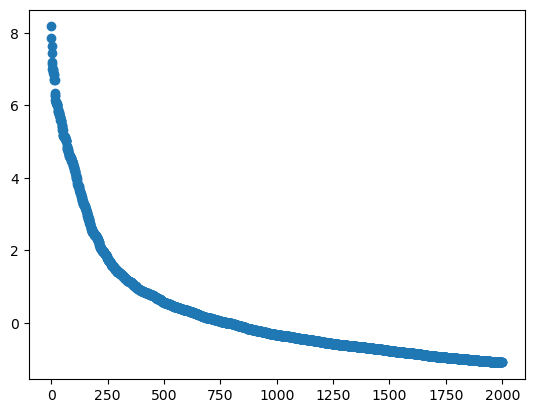

In [10]:
matrix = adata.X
matrix = matrix.todense()
neg_variances = np.sort(-np.var(matrix, axis=0))
sorted_log_variances = [np.log(-i) for i in neg_variances.T][:2000]
plt.scatter([i for i in range(len(sorted_log_variances))], sorted_log_variances)

Data normalization

In [11]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Feature selection

/home/matteo/miniconda3/envs/cotan/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


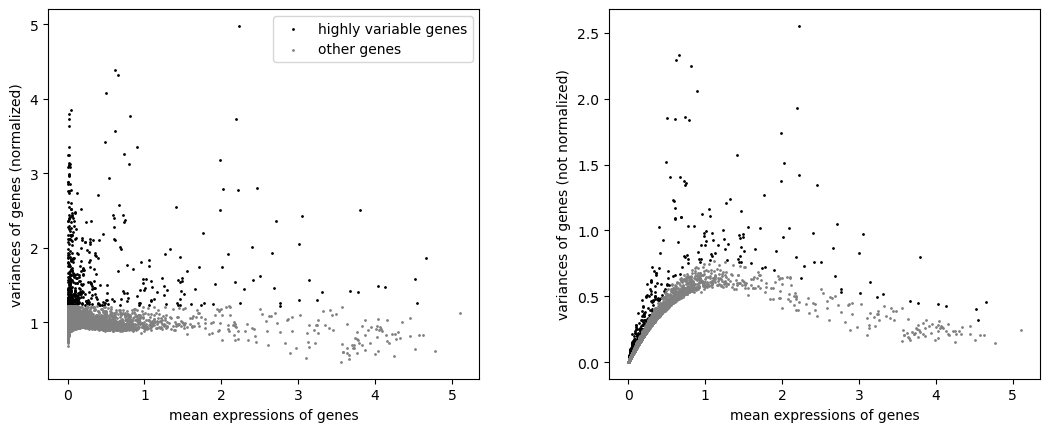

In [14]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=500, # chosen based on elbow plot above
    flavor='seurat_v3'
)
sc.pl.highly_variable_genes(adata)

Feature scaling

In [15]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
# sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) # analogous to Seurat's regressOut, not done in Seurat pipeline
sc.pp.scale(adata, max_value=10) # FIXME: 10 in the tutorial, default None

/home/matteo/miniconda3/envs/cotan/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Clustering

Plot pca explained variance ratio to choose number of components

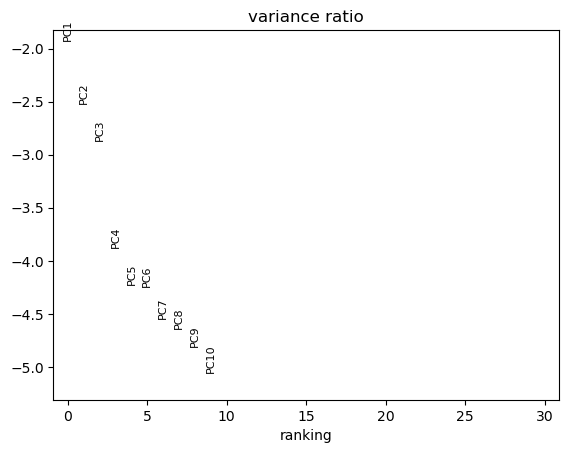

In [17]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=10, use_highly_variable=True)
sc.pl.pca_variance_ratio(adata, log=True)

Perform the clustering

In [18]:
sc.pp.neighbors(
    adata,
    #n_neighbors=20, # FIXME: how to choose this? default is 15, 10 in the tutorial (3k PBMCs from a Healthy Donor), 20 in scivi tutorial
                    # it is the number of nearest neighbors to be searched
                    # "Larger values result in more global views of the manifold,
                    #  while smaller values result in more local data being preserved"
    n_pcs=8 # chosen based on elbow plot above
)
res = 0.7
sc.tl.leiden(adata, resolution=res)
while not (adata.obs.leiden.values.categories.values).shape == (num_of_clusters, ):
    print(f"Clustering with resolution={res}...")
    res += 0.005
    sc.tl.leiden(adata, resolution=res)

/home/matteo/miniconda3/envs/cotan/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Clustering with resolution=0.7...
Clustering with resolution=0.705...


Visualize the clustering in the PCA space

/home/matteo/miniconda3/envs/cotan/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/matteo/miniconda3/envs/cotan/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


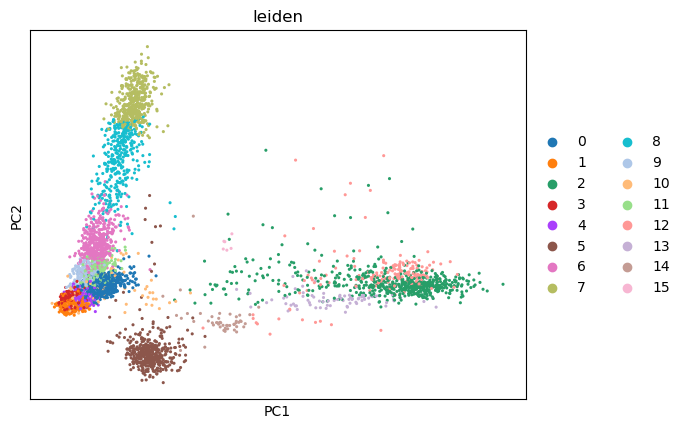

In [19]:
sc.pl.pca(
    adata,
    color=['leiden'],
    size=20
)

Save the clustering results

In [20]:
df = pd.DataFrame(adata.obs['leiden'])
labels = df.rename(columns={'leiden': 'cluster'})
labels.index.name = 'cell'
labels['cluster'] = labels['cluster'].astype(int) + 1
labels.to_csv(f'{save_path}/clustering_labels.csv', index=True)

## Differential expression

In [21]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon') # FIXME: is this method okay?

/home/matteo/miniconda3/envs/cotan/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Save markers

In [13]:
number_of_markers = 500
df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])
for i in range(num_of_clusters):
    indices = np.argsort(adata.uns['rank_genes_groups']['pvals_adj'][str(i)])
    genes = adata.uns['rank_genes_groups']['names'][str(i)][indices][:number_of_markers]
    ranks = rankdata(adata.uns['rank_genes_groups']['pvals_adj'][str(i)][indices][:number_of_markers], method="ordinal")
    df_to_add = pd.DataFrame(
        np.column_stack((genes, [i+1 for _ in range(number_of_markers)], ranks)),
        columns=['gene', 'cluster', 'rank']
    )
    df = pd.concat([df, df_to_add], ignore_index=True)

df['cluster'] = df['cluster'].astype(int)
df['rank'] = df['rank'].astype(int)
df.to_csv(f'{save_path}/markers.csv', index=False)